In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
class FoodStorage:

    def __init__(self, startingInsectFood, startingLegacyFood, percentInsect):
        """
        Args:
        startingInsectFood (int): amount of insect food in kg.
        startingLegacyFood (int): amount of "legacy" food in kg.
        percentInsect (float)   : percentage of insectfood in animalfeed.
        """
        self.co2PerInsect = 1
        self.co2PerLegacy = 2
        self.insectFood = startingInsectFood
        self.legacyFood = startingLegacyFood
        self.percentInsect = percentInsect
        self.totalFood = self.insectFood + self.legacyFood
        self.minFood = (self.totalFood, currentDate)

    def eatFood(self, eaten):
        """
        Args:
        eaten (int/float): Amount eaten in kg .
        
        Returns: 
        co2 (float): CO2 emission from eaten amount.
        """
        co2 = 0
        if self.insectFood >= eaten*self.percentInsect:
            self.insectFood -= eaten*self.percentInsect
            self.legacyFood -= eaten*(1-self.percentInsect)
            co2 += eaten*self.percentInsect*self.co2PerInsect
            co2 += eaten*(1-self.percentInsect)*self.co2PerLegacy
        else:
            self.legacyFood -= eaten
            co2 = eaten*self.co2PerLegacy
        self.totalFood = self.insectFood + self.legacyFood
        if self.totalFood < self.minFood[0]:
            self.minFood = (self.totalFood, currentDate)
        return co2
        
    def addInsectFood(self, add):
        """
        Args:
        add (int): amount of insectfood added to storage.
        """
        self.insectFood += add
        
    def addLegacyFood(self, add):
        """
        Args:
        add (int): amount of "legacy" food added to storage.
        """
        self.legacyFood += add

In [10]:
class InsectFarm:
    def __init__(self, sqrMeter, insectType, target):
        """
        Args:
        sqrMeter (int): Size of sqr. meters for insectfarm.
        insectType (string): Type of insect ("bi" or "larve").
        target (FoodStorage obj.): Where to put harvested insects.
        """
        insects = {'bi': (1, 14), 'larve': (5, 14)}
        self.nutrition = insects[insectType][0]*sqrMeter
        self.harvestFrequency = datetime.timedelta(days=insects[insectType][1])
        self.nextHarvest = currentDate + self.harvestFrequency
        self.target = target
        self.consumption = 1*sqrMeter
        
    def harvest(self):
        """
        Return:
        self.nutrition (int/float): Amount harvested in kg.
        """
        self.target.addInsectFood(self.nutrition)
        self.nextHarvest = currentDate + self.harvestFrequency
        return self.nutrition

In [17]:
class Piggery:
    def __init__(self, noPigs, nutritionNeeds, sellDate, target):
        """
        Args:
        noPigs (int): Amount of pigs in farm.
        nutritionNeeds (float): Food per pig per day (kg).
        sellDate (int): Days untill pig is sold.
        target (FoodStorage obj.): Where to eat from.
        """
        self.noPigs = noPigs
        self.nutritionNeeds = noPigs*nutritionNeeds
        self.sellDate = currentDate + datetime.timedelta(days=sellDate)
        self.target = target
        
    def eat(self):
        """
        Return:
        self.nutritionNeeds (float): Food eaten (kg).
        co2 (float): CO2 emission from eaten amount.
        """
        co2 = self.target.eatFood(self.nutritionNeeds)
        return self.nutritionNeeds,co2

In [18]:
###############Settings####################
startdate = '01Jan2019'                     
stopdate = '01Jan2020'                      
legacyFillUp = datetime.timedelta(days=7)
legacyFillUpAmount = 30
###########################################

currentDate = datetime.datetime.strptime(startdate, '%d%b%Y')
stopDate = datetime.datetime.strptime(stopdate, '%d%b%Y')
refillDate = currentDate + legacyFillUp

food = FoodStorage(startingInsectFood=11, startingLegacyFood=40, percentInsect=0.6)
farm = InsectFarm(sqrMeter=11, insectType='larve', target=food)
piggery = Piggery(noPigs=1, nutritionNeeds=10, sellDate=60, target=food)

df = pd.DataFrame(columns=['Month', 'Consumption', 'Harvest','CO2Emission'])
df = df.set_index('Month')

while currentDate != stopDate:
    # Add month/year(Sep19) row if not already present.
    if currentDate.strftime("%b%y") not in df.index.tolist():
        df.loc[currentDate.strftime("%b%y")] = [0,0,0]
    
    if currentDate == refillDate:
        food.addLegacyFood(legacyFillUpAmount)      
    
    if currentDate == farm.nextHarvest:
        df.loc[currentDate.strftime("%b%y")].Harvest += farm.harvest()
    
    consumption,co2 = piggery.eat()
    df.loc[currentDate.strftime("%b%y")].Consumption += consumption
    df.loc[currentDate.strftime("%b%y")].CO2Emission += co2
    
    currentDate = currentDate+datetime.timedelta(days=1)

14 days, 0:00:00
2019-01-15 00:00:00


In [19]:
df

,Consumption,Harvest,CO2Emission
Month,,,
Jan19,310,110,536
Feb19,280,110,452
Mar19,310,110,494
Apr19,300,110,474
May19,310,110,506
Jun19,300,110,492
Jul19,310,165,494
Aug19,310,110,494
Sep19,300,110,480


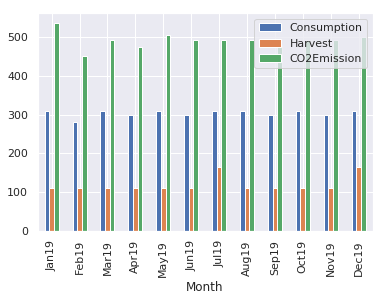

In [104]:
sns.set()
df.plot(kind='bar', stacked=False)

In [101]:
class Piggery:
    def __init__(self, startNoPiglets, startNoPigs, pigletNutritionNeeds, pigNutritionNeeds, gestation, sellDate, target):
        """
        Args:
        noPigs (int): Amount of pigs in farm.
        nutritionNeeds (float): Food per pig per day (kg).
        sellDate (int): Days untill pig is sold.
        target (FoodStorage obj.): Where to eat from.
        
        # https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0141878.s001
        # Link with info regarding pig gestation
        """
        self.noPiglets = startNoPiglets
        self.noPigs = startNoPigs
        self.pigletNutritionNeeds = self.noPigs*pigletNutritionNeeds
        self.pigNutritionNeeds = self.noPigs*pigNutritionNeeds
        self.gestation = datetime.timedelta(gestation)
        self.newPigletsDate = currentDate + self.gestation
        self.sellFrequency = datetime.timedelta(sellDate)
        self.nextSell = currentDate + self.sellFrequency
        self.target = target
                
    def addPiglets(self, add):
        self.noPiglets += add
    
    def add(self):
        self.addPiglets(self.noPiglets)
        self.newPigletsDate = currentDate + self.gestation
        return self.noPiglets
    
    def movePiglets(self, move):
        self.noPiglets -= move
        self.noPigs += move
        return self.noPiglets, self.noPigs
        
    def sellPigs(self, sold):
        self.noPigs -= sold
        
    def sell(self):
        self.sellPigs(self.noPigs)
        self.nextSell = currentDate + self.sellFrequency
        return self.noPigs

    def eat(self):
        """
        Return:
        self.nutritionNeeds (float): Food eaten (kg).
        co2 (float): CO2 emission from eaten amount.
        """
        co2 = self.target.eatFood(self.nutritionNeeds)
        return self.nutritionNeeds,co2

In [102]:
###############Settings####################
startdate = '01Jan2019'                     
stopdate = '01Jan2020'
###########################################

currentDate = datetime.datetime.strptime(startdate, '%d%b%Y')
stopDate = datetime.datetime.strptime(stopdate, '%d%b%Y')

piggery = Piggery(startNoPiglets=10, startNoPigs=10, pigletNutritionNeeds=5, pigNutritionNeeds=4, 
                  gestation=115, sellDate=84, target=food)

df = pd.DataFrame(columns=['Month', 'Piglets', 'Pigs'])
df = df.set_index('Month')

while currentDate != stopDate:
    # Add month/year(Sep19) row if not already present.
    if currentDate.strftime("%d%b%y") not in df.index.tolist():
        df.loc[currentDate.strftime("%d%b%y")] = [0,0]
    
    if currentDate == piggery.newPigletsDate:
        df.loc[currentDate.strftime("%d%b%y")].Piglets += piggery.add()
    
    if currentDate == piggery.nextSell:
        df.loc[currentDate.strftime("%d%b%y")].Pigs += piggery.sell()
    
    piglets,pigs = piggery.movePiglets(10)
    df.loc[currentDate.strftime("%d%b%y")].Piglets += piglets
    df.loc[currentDate.strftime("%d%b%y")].Pigs += pigs
    
    currentDate = currentDate+datetime.timedelta(days=1)

In [103]:
df

,Piglets,Pigs
Month,,
01Jan19,0,20
02Jan19,-10,30
03Jan19,-20,40
04Jan19,-30,50
05Jan19,-40,60
06Jan19,-50,70
07Jan19,-60,80
08Jan19,-70,90
09Jan19,-80,100
